In [1]:
# This notebook loads responses from the Vaximap Impact Google Form 

# We intend to show the following:
    # Time spent planning the route, as a function of route size
    # Using the submitted routes to determine time to complete the route
    # Qualitative data on ease of planning routes and comparative ease of using Vaximap
    
# We will then use these results to estimate the time savings using Vaximap

In [2]:
# To load the Google Forms data

# Go to the response for the Impact assessment on Google Forms 
# (https://docs.google.com/forms/d/1ZR8qlDd8TmFP8ELsby0fWtbJ_1w8k8TwHCazUbKWGLE/edit#responses)

# Click 'Download Responses (.csv)'
# Unzip the downloaded folder and copy the .csv file to the analysis/ subfolder

In [3]:
# Load libraries
import pandas as pd
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import descartes
import geopandas as gpd
import shapely


In [4]:
# Load data
data = pd.read_csv('Vaximap Impact Survey.csv')

# Load dataset
import sys
sys.path.append('../')
from load_dataset import dataset

# Config variables

# Shift to centre of UK
uk_centre_lat = 53
uk_centre_long = -1.2

# Define bounds
max_uk_lat = 60
min_uk_lat  = 50
max_uk_long = 4
min_uk_long = -10

In [5]:
# Define the postcodes in route finding tasks
route1=['OX1 4LB','OX5 1PJ','OX4 2HH']
route2=['OX1 4LB','OX1 4EH','OX4 2HH','OX5 1PJ','OX3 8HH']
route3=['OX1 4EH','OX1 4LB','OX14 3DP','OX5 1PJ','OX4 2HH','OX2 9QN','OX4 2JT','OX3 8HH','OX44 9NG']

# Tidy up the column names for ease of reading's sake. Only have to do this once:
data = data.rename(columns={
    
    str(data.columns[0]): "timestamp",
    str(data.columns[1]): "occupation",
    str(data.columns[2]): "technicality",
    
    str(data.columns[3]): route1[0],
    str(data.columns[4]): route1[1],
    str(data.columns[5]): route1[2],
    str(data.columns[6]): "complete1",
    
    str(data.columns[7]): route2[0],
    str(data.columns[8]): route2[1],
    str(data.columns[9]): route2[2],
    str(data.columns[10]): route2[3],
    str(data.columns[11]): route2[4],
    str(data.columns[12]): "complete2",
    
    str(data.columns[13]): route3[0],
    str(data.columns[14]): route3[1],
    str(data.columns[15]): route3[2],
    str(data.columns[16]): route3[3],
    str(data.columns[17]): route3[4],
    str(data.columns[18]): route3[5],
    str(data.columns[19]): route3[6],
    str(data.columns[20]): route3[7],
    str(data.columns[21]): route3[8],
    str(data.columns[22]): "complete3",
    
    str(data.columns[23]): "difficulty",
    str(data.columns[24]): "time_consumption",
    str(data.columns[25]): "excel_ease"  
    
    });

# Inspect data
data.head()

,timestamp,occupation,technicality,OX1 4LB,OX5 1PJ,OX4 2HH,complete1,OX1 4LB,OX1 4EH,OX4 2HH,...,OX5 1PJ,OX4 2HH,OX2 9QN,OX4 2JT,OX3 8HH,OX44 9NG,complete3,difficulty,time_consumption,excel_ease
0,2021/06/27 10:56:11 AM GMT+1,Finance,4,First,Second,Third,00:03,Second,First,Fourth,...,Seven,Sixth,Third,Fifth,Fourth,Nine,00:14,5,5,2
1,2021/06/27 7:28:50 PM GMT+1,Student,5,Second,Third,First,00:01,Third,Fourth,First,...,Nine,Third,Sixth,Fourth,First,Second,00:04,4,5,1
2,2021/06/27 9:55:09 PM GMT+1,IT,5,First,Third,Second,00:02,Second,First,Fourth,...,Sixth,Third,Seven,Fifth,Fourth,Eight,00:10,3,5,1
3,2021/06/28 11:10:13 AM GMT+1,Student,5,Second,Third,First,00:02,Second,First,Fourth,...,Nine,Third,Eight,Fifth,Fourth,Sixth,00:20,4,5,1
4,2021/06/28 11:19:04 AM GMT+1,Civil Servant,4,Second,Third,First,00:02,Second,First,Fourth,...,Fourth,Sixth,Third,Seven,Fifth,Eight,00:07,4,3,1


In [6]:
# Tidy up answers to map from 'first', 'second', 'third' etc. to 1,2,3
# Index from 1, to avoid confusion
order_dict= {
    "First": 1,
    "Second": 2,
    "Third": 3,
    "Fourth": 4,
    "Fifth": 5,
    "Sixth": 6,  
    "Seven": 7,
    "Eight": 8,
    "Nine": 9,
    }
    
# Replace all values
data.replace(order_dict, inplace=True)


# And convert completion times to floats (in minutes)
def to_minutes(x):
    return (60*float(x.split(':')[0])) + float(x.split(':')[1])

# Apply to_minutes to completion columns
data['complete1'] = data.apply(lambda x: to_minutes(x.complete1), axis=1)
data['complete2'] = data.apply(lambda x: to_minutes(x.complete2), axis=1)
data['complete3'] = data.apply(lambda x: to_minutes(x.complete3), axis=1)

# Inspect head
data.head()

,timestamp,occupation,technicality,OX1 4LB,OX5 1PJ,OX4 2HH,complete1,OX1 4LB,OX1 4EH,OX4 2HH,...,OX5 1PJ,OX4 2HH,OX2 9QN,OX4 2JT,OX3 8HH,OX44 9NG,complete3,difficulty,time_consumption,excel_ease
0,2021/06/27 10:56:11 AM GMT+1,Finance,4,1,2,3,3.0,2,1,4,...,7,6,3,5,4,9,14.0,5,5,2
1,2021/06/27 7:28:50 PM GMT+1,Student,5,2,3,1,1.0,3,4,1,...,9,3,6,4,1,2,4.0,4,5,1
2,2021/06/27 9:55:09 PM GMT+1,IT,5,1,3,2,2.0,2,1,4,...,6,3,7,5,4,8,10.0,3,5,1
3,2021/06/28 11:10:13 AM GMT+1,Student,5,2,3,1,2.0,2,1,4,...,9,3,8,5,4,6,20.0,4,5,1
4,2021/06/28 11:19:04 AM GMT+1,Civil Servant,4,2,3,1,2.0,2,1,4,...,4,6,3,7,5,8,7.0,4,3,1


In [7]:
# Start building some summary statistics

print("Total number of completions = ",len(data))
print("Average time to complete route 1 = ",round(np.mean(data['complete1']),2)," minutes.")
print("Average time to complete route 2 = ",round(np.mean(data['complete2']),2)," minutes.")
print("Average time to complete route 3 = ",round(np.mean(data['complete3']),2)," minutes.")

Total number of completions =  13
Average time to complete route 1 =  2.08  minutes.
Average time to complete route 2 =  4.38  minutes.
Average time to complete route 3 =  6.46  minutes.


In [8]:
##### Planning a route #####

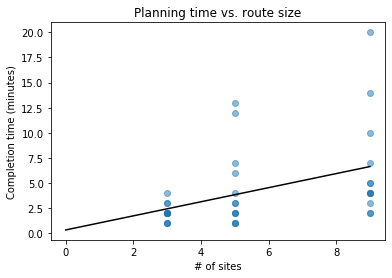

In [9]:
# Plot completion time vs. route length
y = data['complete1'].append(data['complete2']).append(data['complete3'])
x0 = [1 for i in range(0,3*len(data))]
x1 = [3 for i in range(0,len(data))]+[5 for i in range(0,len(data))]+[9 for i in range(0,len(data))]

# Generate model params
lr = LinearRegression(fit_intercept=False)
X = np.array([x0,x1],dtype="float32").transpose()
reg = lr.fit(X, y.values)
reg.score(X, y)

# Make prediction
Xpred1 = np.linspace(0, X.max(), num=10).tolist()
Xpred0 = [1 for i in range(0,len(Xpred1))]
Xpred = np.array([Xpred0,Xpred1],dtype="float32").transpose()

# Plot 
plt.scatter(x1,y, alpha=0.5)
plt.plot(Xpred[:,1],reg.predict(Xpred),color='k')
plt.ylabel('Completion time (minutes)')
plt.xlabel('# of sites')
plt.title('Planning time vs. route size')
plt.show()

In [10]:
# Get minutes per sites
print("Approx. minute per site: ",round(reg.coef_[1],2))

Approx. minute per site:  0.7


In [11]:
# Calculate overall time saving
print("Total number of patients: ",sum(dataset.n_patients))
print("Total planning time: ",int(reg.coef_[1]*sum(dataset.n_patients)/60)," hours.")
print("Total planning time: ",int(reg.coef_[1]*sum(dataset.n_patients)/(60*24))," days.")
print("Total planning time: ",int(reg.coef_[1]*sum(dataset.n_patients)/(60*8))," worker days.")

# Map time saving into cost
avg_hourly_rate = 15
print("Total cost saving: £",int(reg.coef_[1]*sum(dataset.n_patients)/60)*avg_hourly_rate,".")


Total number of patients:  286924
Total planning time:  3350  hours.
Total planning time:  139  days.
Total planning time:  418  worker days.
Total cost saving: £ 50250 .


In [12]:
##### Illustrating location of sites around UK #####

In [13]:
def flatten(t):
    return [item for sublist in t for item in sublist]

# Get all 
latlongs = flatten(dataset['latlong'])
lats = [uk_centre_lat+x[0] for x in latlongs]
longs = [uk_centre_long+x[1] for x in latlongs]

# make bespoke dataframe
df = pd.DataFrame(
    {'lats': lats,
     'longs': longs,
    })

print("Number of points: ",len(lats))
print("Number of points: ",len(longs))
print("Max lat: ",max(lats),". Min lat: ",min(lats))
print("Max long: ",max(longs),". Min long: ",min(longs))

Number of points:  286924
Number of points:  286924
Max lat:  61.901177895454545 . Min lat:  17.548534313837685
Max long:  47.605446982383725 . Min long:  -90.953649925


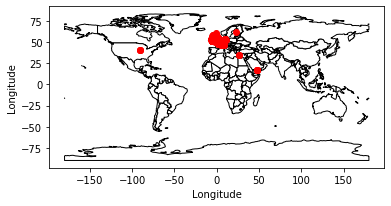

In [14]:
# Plot for whole world

# Being geo plot
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(longs, lats))

# plotting coordinates over a country level map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot for world
ax = world.plot(
    color='white', edgecolor='black')

# then plot the geodataframe on this
gdf.plot(ax=ax, color='red')
plt.xlabel('Longitude')
plt.ylabel('Longitude')
plt.show()

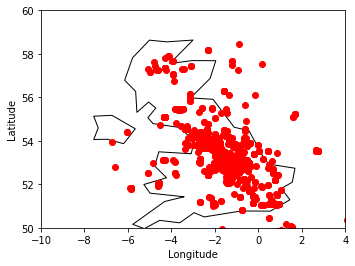

In [15]:
# Plot for UK only

# Get all in UK
latlongs = flatten(dataset['latlong'])
lats = [uk_centre_lat+x[0] for x in latlongs]
longs = [uk_centre_long+x[1] for x in latlongs]

# make bespoke dataframe
df2 = pd.DataFrame(
    {'lats': lats,
     'longs': longs,
    })

# Being geo plot
gdf = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(longs, lats))

# then restrict this to the United Kingdom
ax = world[(world.name == "United Kingdom")].plot(
color='white', edgecolor='black')

# then plot the geodataframe on this
gdf.plot(ax=ax, color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.axis(xmin=min_uk_long,xmax=max_uk_long)
ax.axis(ymin=min_uk_lat,ymax=max_uk_lat)
plt.show()

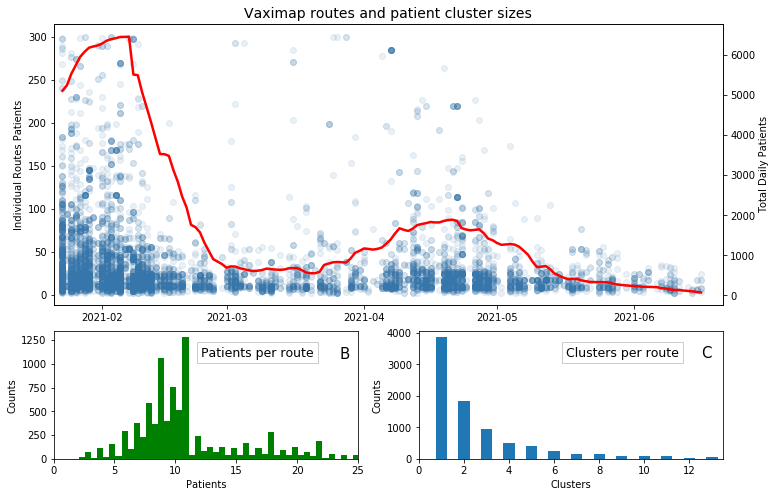

In [16]:
# Descriptive stats plot - production

from io import BytesIO
import tarfile
from urllib.request import urlopen
import pandas as pd
import datetime

# sort the dataframe by date created
dataset['created'] = pd.to_datetime(dataset.created)
dataset = dataset.sort_values(by='created')

# define average patients per cluster
dataset['patients_per_cluster'] = (dataset['n_patients']/dataset['n_clusters'])

# get the raw data
y = dataset.n_patients
x = dataset.created

# bin the data by date
binned = dataset['n_patients'].groupby(dataset['created']).sum()
x_binned = binned.index
y_binned = binned.values

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def add_titlebox(ax, text):
    ax.text(.67, .8, text,
        horizontalalignment='center',
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.2),
         fontsize=12.5)
    return ax

# Make the plot
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))

# Define some axes
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_xlim([datetime.date(2021, 1, 21), datetime.date(2021, 11, 1)])
ax11= ax1.twinx()
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))

# Headline figure
ax1.set_title('Vaximap routes and patient cluster sizes',
              fontsize=14)
sctr = ax1.scatter(x, y, color='#3776ab',alpha=0.1)
y_av = movingaverage(y_binned, 30)
ax11.plot(x_binned, y_av,"r",linewidth=2.5)
ax1.set_yscale('linear')
ax1.set_ylabel('Individual Routes Patients')
#ax1.text(0.8, 0.8, r'A', fontsize=15,transform=ax.transAxes)
ax11.set_ylabel('Total Daily Patients')

# Patients per route
binwidth=0.5
ax2.hist(dataset.patients_per_cluster, bins=np.arange(min(dataset.patients_per_cluster), 
                                                      max(dataset.patients_per_cluster) + binwidth, binwidth),
         color='green',align='left')
ax2.axis(xmin=0,xmax=25)
ax2.set_ylabel('Counts')
ax2.set_xlabel('Patients')
ax2.text(23.5, 1050, r'B', fontsize=15)

# Clusters per route
binwidth=0.5
ax3.hist(dataset.n_clusters, bins=np.arange(min(dataset.n_clusters), 
                                            max(dataset.n_clusters) + binwidth, binwidth),align='left')
ax3.axis(xmin=0,xmax=13.5)
ax3.set_ylabel('Counts')
ax3.set_xlabel('Clusters')
ax3.text(12.5, 3200, r'C', fontsize=15)

add_titlebox(ax2, 'Patients per route')
add_titlebox(ax3, 'Clusters per route')
fig.savefig('summary_v0.png', dpi=fig.dpi)

In [17]:
import pandas as pd
import json
from urllib.request import urlopen
import numpy as np
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature

#Load GeoJson 
with urlopen('https://opendata.arcgis.com/datasets/48b6b85bb7ea43699ee85f4ecd12fd36_4.geojson') as response:
    counties = json.load(response)
    
#Transform counties dict
counties2 = pd.json_normalize(counties,max_level=1)
counties2 = counties2.features[0]
counties2 = pd.json_normalize(counties2,max_level=1)
    
dummy_data=pd.read_csv('https://opendata.arcgis.com/datasets/48b6b85bb7ea43699ee85f4ecd12fd36_0.csv?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D')

#add dummy data
dummy_data['value']=np.random.randint(10, 100, size=len(dummy_data))

In [102]:
# Get list of latlongs and find which county they're in

latlongs = flatten(dataset['latlong'])
latlongs = pd.DataFrame (latlongs, columns = ['lat','long'])
latlongs['properties.nuts218cd'] = 'NA'

# Shift to centre of UK
latlongs['lat'] = latlongs['lat']+uk_centre_lat
latlongs['long'] = latlongs['long']+uk_centre_long

for index,row in latlongs.iterrows():
    if (index % 10000 ==0):
        print(index)
    for index2, row2 in counties2.iterrows():
        lst = row2['geometry.coordinates']
        lst2 = [[tuple(x) for x in lst[0]]]
        polygon = Polygon(lst2)
        point = Feature(geometry=Point((row['long'], row['lat'])))
        in_poly = boolean_point_in_polygon(point, polygon)
        if in_poly:
            latlongs.loc[index,'properties.nuts218cd'] = row2['properties.nuts218cd']

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000


In [103]:
# Save latlongs to pickle
latlongs.to_pickle("./latlongs.pkl")

In [152]:
#With Plotly
import plotly.express as px
from geojson_rewind import rewind

# read from latlongs
latlongs = pd.read_pickle("./latlongs.pkl")

# groupby county
latlongs['value'] = 1
latlongs2 = latlongs['value'].groupby(latlongs['properties.nuts218cd']).sum().reset_index()

county_df = pd.DataFrame (counties2['properties.nuts218cd'].unique(), columns = ['properties.nuts218cd'])
county_df['value'] = 0
county_df = pd.merge(county_df,latlongs2,on='properties.nuts218cd',how='left')
county_df['value'] = county_df['value_y']
county_df = county_df.fillna(1)
county_df['value'] = np.log(np.sqrt(county_df['value']))

#Make the rings clockwwise (to make it compatible with plotly)    
counties_corrected=rewind(counties,rfc7946=False)

fig = px.choropleth(county_df, geojson=counties_corrected, locations='properties.nuts218cd', featureidkey="properties.nuts218cd", color='value',
                            color_continuous_scale="PurPor", labels={'label name':'label name'}, title='',
                            scope="europe")

fig.update_geos(fitbounds="locations", visible=False)
fig.write_image("uk_v0.png")


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
